In [1]:
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import plotly.express as px

mpl.rc('font', family='Malgun Gothic')

In [2]:
# !pip install --user imblearn

In [3]:
df1 = pd.read_csv('01_Data.csv')

In [4]:
# 1. 'Amount_Month'(월랜탈비용)과 'Term'(계약기간)데이터를 곱하여, 
# 계약기간동안 한명의 회윈이 총 납부하는 총금액('Total_Amount') 항목을 계산하여 새로운 변수로 선언 
df1['Total_Amount'] = df1['Amount_Month'] * df1['Term']
df1['Total_Amount'].describe()

count    5.130100e+04
mean     5.315394e+06
std      1.455794e+06
min      6.624000e+05
25%      4.914000e+06
50%      5.814000e+06
75%      5.814000e+06
max      1.006200e+07
Name: Total_Amount, dtype: float64

In [5]:
# 2. 총금액('Total_Amount')값에 따라 고객의 등급을 분류해보고자 한다.
#    총금액('Total_Amount')값이 상위 10% 고객은 'VIP'
#    총금액('Total_Amount')값이 상위 30% 고객은 'Special'
#    나머지 고객 'Normal' 값으로 계산하여 'Member_Rank'변수를 생성 
cond1 = (df1['Total_Amount'] >= df1['Total_Amount'].quantile(0.9) )
cond2 = (df1['Total_Amount'] >= df1['Total_Amount'].quantile(0.7) )

df1['Member_Rank'] = 'Normal'
df1.loc[cond2, 'Member_Rank'] = 'Special'
df1.loc[cond1, 'Member_Rank'] = 'VIP'
df1['Member_Rank'].value_counts()

Special    21145
Normal     20909
VIP         9247
Name: Member_Rank, dtype: int64

In [6]:
# 3. 앞서 계산된 'Member_Rank'에서 'VIP'고객들의 특성을 파악하고 한다. 
#  'VIP'고객들만 추출하여, 'Channel'(유입경로)에 따른 'Total_Amount'(총금액)의 평균을 시각화 / 합 시각화 
cond1 = (df1['Member_Rank']=='VIP')
p1 = df1.loc[cond1].pivot_table(index='Channel',values='Total_Amount',
                                 aggfunc=['mean','sum']).reset_index()

In [7]:
p1.columns= p1.columns.droplevel(1)

<AxesSubplot:xlabel='mean', ylabel='Channel'>

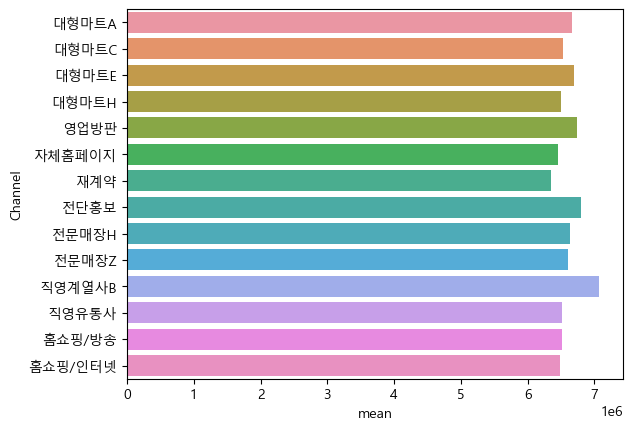

In [8]:
sns.barplot(data=p1, y='Channel', x='mean')

<AxesSubplot:xlabel='sum', ylabel='Channel'>

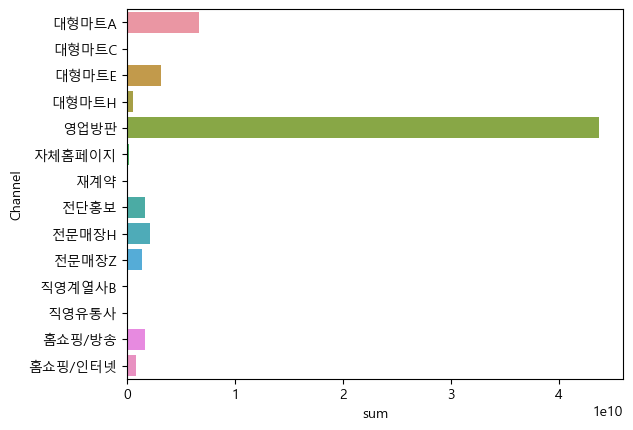

In [9]:
sns.barplot(data=p1, y='Channel', x='sum')

<AxesSubplot:xlabel='value', ylabel='Channel'>

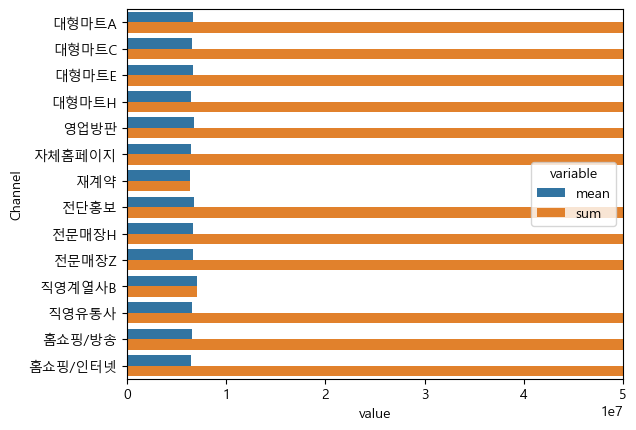

In [10]:
plt.xlim([0, 50000000])
sns.barplot(data = p1.melt(id_vars='Channel') ,
                         y='Channel', x='value', hue='variable')

<AxesSubplot:xlabel='value', ylabel='Channel'>

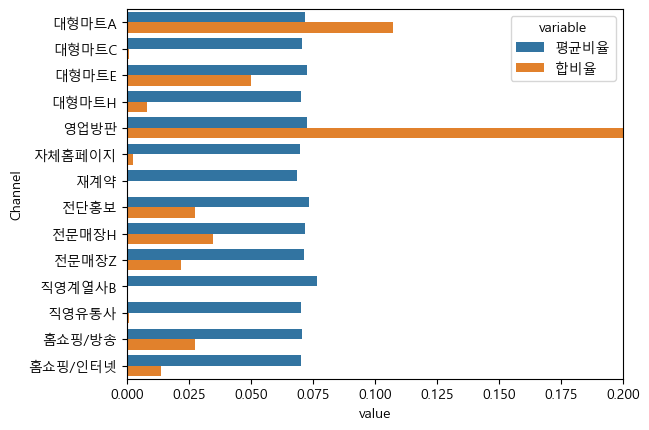

In [11]:
p1['평균비율']= p1['mean'] / p1['mean'].sum()
p1['합비율']  = p1['sum'] / p1['sum'].sum()
p1_ratio = p1[['Channel','평균비율','합비율']].melt(id_vars='Channel')

plt.xlim([0, 0.2])
sns.barplot(data= p1_ratio, y='Channel', x='value', hue='variable')

In [12]:
# 4. 'VIP'고객들의 'Channel'(유입경로)에서 Total_Amount값의 합이 가장 높은 상위 3개의 경로를 선택하여, 
#     각 경로 별 Total_Amount값의 평균의 유의미한 차이가 있는지 가설검정 수행
top3_list= p1.sort_values(by='sum',ascending=False)['Channel'].head(3).values.tolist()
cond1 = df1['Channel'].isin(top3_list)
df1_top= df1.loc[cond1]

In [13]:
# 4-1. Total_Amount 정규성을 띄는가? 
# 귀무 가설 :  Total_Amount값이 정규분포와 차이가 없다. 
# 대립 가설 :  Total_Amount값이 정규분포와 차이가 있다. 
stats.normaltest(df1_top['Total_Amount']) # P.value < 0.05 / 대립가설 참 
# Total_Amount값이 정규분포와 차이가 있다.

NormaltestResult(statistic=13082.036799757741, pvalue=0.0)

In [14]:
# 4-2. 정규분포를 띄지않는 연속형 데이터에 대해 3집단 간 평균 비교 
# 귀무 가설 : 세 집단의 평균은 차이가 없다. (세 집단 모두 평균이 같다고 볼 수 있다.) 
# 대립 가설 : 세 집단의 평균의 차이가 있다. (세 집단 중 한 집단 이상의 평균이 다르다고 볼 수 있다.)
cond1 = (df1_top['Channel'] == top3_list[0]) 
cond2 = (df1_top['Channel'] == top3_list[1]) 
cond3 = (df1_top['Channel'] == top3_list[2]) 
df1_top1 = df1_top.loc[cond1]
df1_top2 = df1_top.loc[cond2]
df1_top3 = df1_top.loc[cond3]
stats.kruskal(df1_top1['Total_Amount'], df1_top2['Total_Amount'], 
              df1_top3['Total_Amount'])
# P.value < 0.05 / 대립가설 참 / 세 집단의 평균의 차이가 있다.

KruskalResult(statistic=145.18243768172138, pvalue=2.978751148361835e-32)

<AxesSubplot:xlabel='Member_Rank', ylabel='count'>

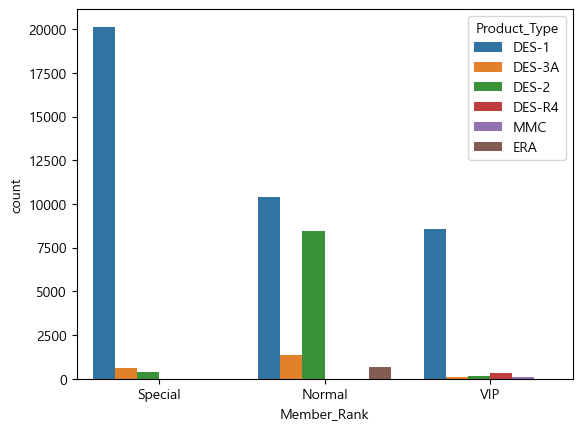

In [15]:
# 5. 'Member_Rank'고객의 등급에 따라 사용하는 
#    'Product_Type'제품군이 달라지는 지 확인해 보고자 한다. 
#    - 고객의 등급과 제품군의 빈도수를 나타는 그래프를 시각화  
#    - 고객의 등급과 제품군 간의 연관성이 있는지 가설검정을 수행 
sns.countplot(data=df1, x='Member_Rank', hue='Product_Type')

In [16]:
# 5-2. 고객의 등급과 제품군 간의 연관성이 있는지 가설검정을 수행 
# 귀무 : 고객의 등급과 제품군 간의 연관성이 없다. (독립이다.)
# 대립 : 고객의 등급과 제품군 간의 연관성이 있다. (연관이있다.)
df1_table = pd.crosstab(df1['Member_Rank'],df1['Product_Type'])
stats.chi2_contingency(df1_table)
# P.value < 대립가설 참 / 고객의 등급과 제품군 간의 연관성이 있다.

(17400.408970458084,
 0.0,
 10,
 array([[15949.62860373,  3666.54381006,   848.16336914,   133.27699265,
           262.47823629,    48.90898813],
        [16129.65215103,  3707.92811056,   857.73659383,   134.78129081,
           265.44082961,    49.46102415],
        [ 7053.71924524,  1621.52807937,   375.10003704,    58.94171654,
           116.08093409,    21.62998772]]))

In [17]:
# 6. 'Member_Rank'고객 등급에서 'Special' 고객들의 특성을 파악하고자 한다.
#   - 'Datetime'계약일자를 이용하여, 가장 유입이(빈도수) 많이 발생한 '월'을 확인 
#   -  2019년도 / 2020년도 각각 확인 
df1['Datetime_dt'] = pd.to_datetime(df1['Datetime'])
df1['Year'] = df1['Datetime_dt'].dt.year
df1['Month'] = df1['Datetime_dt'].dt.month

In [18]:
cond1 = (df1['Member_Rank']=='Special')
df1_special = df1.loc[cond1]
df1_special['Count'] = 1
df1_special.pivot_table(index='Month',values='Count',columns='Year',aggfunc='sum')

C:\Users\DMC CONET\AppData\Local\Temp\ipykernel_12396\376186506.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1_special['Count'] = 1


Year,2019,2020
Month,,
1,1779.0,785.0
2,2740.0,835.0
3,2014.0,704.0
4,1496.0,553.0
5,1212.0,383.0
6,1118.0,359.0
7,1429.0,563.0
8,969.0,105.0
9,958.0,NaN


In [19]:
# 7. 'Product_Type'제품군 별 연도에 따른 'Total_Amount'총금액의 증감율을 계산하시오. 
p1 = df1.pivot_table(index='Product_Type', values='Total_Amount',
                     columns='Year',aggfunc='sum')

p1['전년대비증감율'] = (p1[2020] - p1[2019]) / p1[2019]
p1

Year,2019,2020,전년대비증감율
Product_Type,,,
DES-1,167173962120,42612206976,-0.745103
DES-2,35856775800,8887944960,-0.752126
DES-3A,9361251360,2384535600,-0.745276
DES-R4,2007975600,506232000,-0.747889
ERA,2454835500,552672900,-0.774864
MMC,684063900,202562100,-0.703884


- 8. Credit_Rank'신용등급'을 예측하는 회귀모델을 만들고자 한다.
-    아래의 조건에 맞춰 회귀모델을 구성하시오. 

In [20]:
# 학습데이터와 검증데이터 분할 
from sklearn.model_selection import train_test_split
# 특성공학과 학습이 수행될 파이프라인 구성 
from imblearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
# 특성공학 
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
#  학습알고리즘
from sklearn.tree import DecisionTreeRegressor
#  교차검증
from sklearn.model_selection import GridSearchCV
#  평가 
from sklearn.metrics import r2_score

In [21]:
X = df1[['Age','Amount_Month','Term','Gender','Product_Type']]
Y = df1['Credit_Rank'].fillna( df1['Credit_Rank'].median() )  # fillna 결측처리 

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, random_state=1234)

In [23]:
numeric_pipe = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
category_pipe = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder())
numeric_list = X.describe().columns.tolist()
category_list = X.describe(include='object').columns.tolist()

preprocessing_pipe = make_column_transformer((numeric_pipe,numeric_list),
                                             (category_pipe,category_list))
model_pipe = make_pipeline(preprocessing_pipe, DecisionTreeRegressor())

In [24]:
grid_model = GridSearchCV(model_pipe, cv=3, param_grid={}, n_jobs= -1)
grid_model.fit(X_train, Y_train)
best_model = grid_model.best_estimator_

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
def evaluation_reg_fun1(model):
    Y_train_pred = model.predict(X_train)
    Y_test_pred  = model.predict(X_test)
    print('학습 성능 (R)', r2_score(Y_train, Y_train_pred) )
    print('일반화 성능 (R)', r2_score(Y_test, Y_test_pred) )
    print('학습 성능 (MSE)', mean_squared_error(Y_train, Y_train_pred) )
    print('일반화 성능 (MSE)', mean_squared_error(Y_test, Y_test_pred) )

In [27]:
evaluation_reg_fun1(best_model)

학습 성능 (R) 0.12535693861358532
일반화 성능 (R) -0.05556882339140645
학습 성능 (MSE) 3.5997204068390385
일반화 성능 (MSE) 4.222255966805739


In [28]:
# 9. 'Product_Type' 별 계약건수 대비 총금액(Total_Amount)을 나눈 값을 계산하시오. 
df1['Count'] = 1 
p1 = df1.pivot_table(index='Product_Type', 
                     values=['Total_Amount','Count'], aggfunc='sum')
p1['Mean'] = p1['Total_Amount'] / p1['Count']
p1

,Count,Total_Amount,Mean
Product_Type,,,
DES-1,39133,209786169096,5.360851e+06
DES-2,8996,44744720760,4.973846e+06
DES-3A,2081,11745786960,5.644299e+06
DES-R4,327,2514207600,7.688708e+06
ERA,644,3007508400,4.670044e+06
MMC,120,886626000,7.388550e+06


In [29]:
df1.pivot_table(index='Product_Type', 
                     values='Total_Amount', aggfunc='mean')

,Total_Amount
Product_Type,
DES-1,5.360851e+06
DES-2,4.973846e+06
DES-3A,5.644299e+06
DES-R4,7.688708e+06
ERA,4.670044e+06
MMC,7.388550e+06


# 설비 데이터 

In [30]:
df1_detect = pd.read_csv('09_Detection.csv')
df2_process = pd.read_csv('09_Process_A.csv')

In [31]:
df1_detect.head(2)

,Unnamed: 0,date_clean,tag,tag_num,unit,Y1A,Y2A,Y3A
0,0,2018-12-01 03:30:00.000,NE280V,GO1701,Total [1/m²],4954.774,327.416,256.882
1,1,2018-12-01 07:30:00.005,NE280PV,GO1701,Total [1/m²],2281.460,44.410,17.416


In [32]:
df2_process.head(2)

,Unnamed: 0.1,Unnamed: 0,DATE,PERIOD,Label,A1,A2,A3,A4,A5,A6
0,0,0,2018-12-01T00:10:00,P1,AVG,225.637279,228.533316,230.788205,230.634245,232.112927,230.630909
1,1,1,2018-12-01T00:20:00,P1,AVG,225.763044,228.519014,230.428961,230.936762,231.899435,230.564272


In [33]:
df1_detect['datetime']  = pd.to_datetime(df1_detect['date_clean'])
df2_process['datetime'] = pd.to_datetime(df2_process['DATE'])

In [34]:
# 공정데이터를 기준으로 병합 (10분단위)
pd.merge(df2_process, df1_detect, on='datetime', how='left')

,Unnamed: 0.1,Unnamed: 0_x,DATE,PERIOD,Label,A1,A2,A3,A4,A5,A6,datetime,Unnamed: 0_y,date_clean,tag,tag_num,unit,Y1A,Y2A,Y3A
0,0,0,2018-12-01T00:10:00,P1,AVG,225.637279,228.533316,230.788205,230.634245,232.112927,230.630909,2018-12-01 00:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,2018-12-01T00:20:00,P1,AVG,225.763044,228.519014,230.428961,230.936762,231.899435,230.564272,2018-12-01 00:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,2018-12-01T00:30:00,P1,AVG,225.637431,228.040479,230.276102,230.359142,231.650512,230.317974,2018-12-01 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,2018-12-01T00:40:00,P1,AVG,224.906854,227.645375,229.837444,229.830891,231.075795,229.694517,2018-12-01 00:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,2018-12-01T00:50:00,P1,AVG,224.798077,227.710191,229.888123,229.962605,231.004184,229.586533,2018-12-01 00:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10656,10651,10651,2019-09-03T23:20:00,P3,AVG,229.419421,230.737206,231.043314,230.766543,229.620569,227.705867,2019-09-03 23:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10657,10652,10652,2019-09-03T23:30:00,P3,AVG,229.172333,230.566021,230.901487,230.651712,229.510997,227.606733,2019-09-03 23:30:00,472.0,2019-09-03 23:30:00.000,NE282PV,1701,Total [1/m²],15553.431,1237.614,980.762
10658,10653,10653,2019-09-03T23:40:00,P3,AVG,229.333477,230.687242,231.019085,230.721111,229.594107,227.676463,2019-09-03 23:40:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10659,10654,10654,2019-09-03T23:50:00,P3,AVG,229.162736,230.555417,231.024972,230.583142,229.613431,227.703735,2019-09-03 23:50:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [35]:
# 품질데이터를 기준으로 병합 (4시간단위)
pd.merge(df2_process, df1_detect, on='datetime', how='right')

,Unnamed: 0.1,Unnamed: 0_x,DATE,PERIOD,Label,A1,A2,A3,A4,A5,A6,datetime,Unnamed: 0_y,date_clean,tag,tag_num,unit,Y1A,Y2A,Y3A
0,20.0,20.0,2018-12-01T03:30:00,P1,AVG,224.638902,227.413493,229.905499,229.657359,230.931185,229.420348,2018-12-01 03:30:00.000,0,2018-12-01 03:30:00.000,NE280V,GO1701,Total [1/m²],4954.774,327.416,256.882
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-01 07:30:00.005,1,2018-12-01 07:30:00.005,NE280PV,GO1701,Total [1/m²],2281.460,44.410,17.416
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-01 11:30:00.010,2,2018-12-01 11:30:00.010,NE280V,GO1701,Total [1/m²],4453.201,74.017,23.511
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-01 15:30:00.015,3,2018-12-01 15:30:00.015,NE280PV,GO1701,Total [1/m²],4352.190,77.500,37.444
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-01 19:30:00.020,4,2018-12-01 19:30:00.020,NE280V,GO1701,Total [1/m²],4345.224,62.697,40.927
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,10604.0,10604.0,2019-09-03T15:30:00,P3,AVG,228.894231,230.397130,231.012732,230.710081,229.776926,227.902789,2019-09-03 15:30:00.000,469,2019-09-03 15:30:00.000,NE282PV,1701,Total [1/m²],27633.534,3436.123,2903.202
470,10622.0,10622.0,2019-09-03T18:30:00,P3,AVG,229.004528,230.446154,230.866429,230.840892,229.665830,227.779707,2019-09-03 18:30:00.000,470,2019-09-03 18:30:00.000,NE282PV,1701,Total [1/m²],14115.267,951.667,728.541
471,10628.0,10628.0,2019-09-03T19:30:00,P3,AVG,229.249716,230.743679,231.029600,230.840803,229.704163,227.779644,2019-09-03 19:30:00.000,471,2019-09-03 19:30:00.000,NE282PV,1701,Total [1/m²],13207.919,788.144,605.793
472,10652.0,10652.0,2019-09-03T23:30:00,P3,AVG,229.172333,230.566021,230.901487,230.651712,229.510997,227.606733,2019-09-03 23:30:00.000,472,2019-09-03 23:30:00.000,NE282PV,1701,Total [1/m²],15553.431,1237.614,980.762


In [36]:
# 시간 단위 반올림 
df1_detect['dt_round'] = df1_detect['datetime'].round('T') 
# round : 반올림 / 'T' -> 분

In [37]:
pd.merge(df2_process, df1_detect, left_on='datetime',right_on='dt_round',how='right')

,Unnamed: 0.1,Unnamed: 0_x,DATE,PERIOD,Label,A1,A2,A3,A4,A5,...,Unnamed: 0_y,date_clean,tag,tag_num,unit,Y1A,Y2A,Y3A,datetime_y,dt_round
0,20.0,20.0,2018-12-01T03:30:00,P1,AVG,224.638902,227.413493,229.905499,229.657359,230.931185,...,0,2018-12-01 03:30:00.000,NE280V,GO1701,Total [1/m²],4954.774,327.416,256.882,2018-12-01 03:30:00.000,2018-12-01 03:30:00
1,44.0,44.0,2018-12-01T07:30:00,P1,AVG,225.430882,228.297069,230.934893,231.026156,231.795967,...,1,2018-12-01 07:30:00.005,NE280PV,GO1701,Total [1/m²],2281.460,44.410,17.416,2018-12-01 07:30:00.005,2018-12-01 07:30:00
2,68.0,68.0,2018-12-01T11:30:00,P1,AVG,229.063690,230.710820,232.028457,231.395510,231.208500,...,2,2018-12-01 11:30:00.010,NE280V,GO1701,Total [1/m²],4453.201,74.017,23.511,2018-12-01 11:30:00.010,2018-12-01 11:30:00
3,92.0,92.0,2018-12-01T15:30:00,P1,AVG,228.312661,229.785002,230.958881,230.267388,230.243133,...,3,2018-12-01 15:30:00.015,NE280PV,GO1701,Total [1/m²],4352.190,77.500,37.444,2018-12-01 15:30:00.015,2018-12-01 15:30:00
4,116.0,116.0,2018-12-01T19:30:00,P1,AVG,229.209428,230.345179,230.993988,230.115520,229.526814,...,4,2018-12-01 19:30:00.020,NE280V,GO1701,Total [1/m²],4345.224,62.697,40.927,2018-12-01 19:30:00.020,2018-12-01 19:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
469,10604.0,10604.0,2019-09-03T15:30:00,P3,AVG,228.894231,230.397130,231.012732,230.710081,229.776926,...,469,2019-09-03 15:30:00.000,NE282PV,1701,Total [1/m²],27633.534,3436.123,2903.202,2019-09-03 15:30:00.000,2019-09-03 15:30:00
470,10622.0,10622.0,2019-09-03T18:30:00,P3,AVG,229.004528,230.446154,230.866429,230.840892,229.665830,...,470,2019-09-03 18:30:00.000,NE282PV,1701,Total [1/m²],14115.267,951.667,728.541,2019-09-03 18:30:00.000,2019-09-03 18:30:00
471,10628.0,10628.0,2019-09-03T19:30:00,P3,AVG,229.249716,230.743679,231.029600,230.840803,229.704163,...,471,2019-09-03 19:30:00.000,NE282PV,1701,Total [1/m²],13207.919,788.144,605.793,2019-09-03 19:30:00.000,2019-09-03 19:30:00
472,10652.0,10652.0,2019-09-03T23:30:00,P3,AVG,229.172333,230.566021,230.901487,230.651712,229.510997,...,472,2019-09-03 23:30:00.000,NE282PV,1701,Total [1/m²],15553.431,1237.614,980.762,2019-09-03 23:30:00.000,2019-09-03 23:30:00


In [38]:
# 공정 데이터를 30분 단위로 묶어서 통계량을 계산한 다음, 
# 30분 단위로 계산된 공정 값의 평균과 품질 검사 데이터를 병합 
df2_process_30T = df2_process.set_index('datetime').resample('30T').mean()
# set_index : 특정값 (순서/ 날짜)을 Index로 지정 
# resample : 특정 단위 별로 value값을 계산하는 함수 

In [39]:
df2_process_T  = df2_process_30T.reset_index()

- Pandas 시간단위 
- s : 초단위 / T : 분단위 / H : 시간 / D : 일 / B : 평일 기준
- W : 주단위(일) / W-MON : 주단위(월)
- M : 월단위 (마지막일) / MS : 각 달의 첫날
- Q-JAN : 각 분기의 첫달의 마지막 날 / Q-DEC : 각 분기의 마지막달의 마지막 날 

In [40]:
df1_merge = pd.merge(df2_process_T,df1_detect,
                     left_on='datetime',right_on='dt_round',how='right')

In [41]:
# 관리도
# 중심선 : 데이터의 대표값 
# 관리 상한선 (Upper Spec Limit) : (Xbar-sd) 평균 + 3 x (표준편차)
# 관리 하한선 (Lower Spec Limit) : (Xbar-sd) 평균 - 3 x (표준편차)
center = df1_merge['A1'].mean()
USL = center + (df1_merge['A1'].std() * 3)
LSL = center - (df1_merge['A1'].std() * 3)

In [42]:
df1_A1_Xbar = df1_merge[['A1']].reset_index()
df1_A1_Xbar['Center'] = center
df1_A1_Xbar['USL'] = USL
df1_A1_Xbar['LSL'] = LSL
df1_A1_Xbar

,index,A1,Center,USL,LSL
0,0,224.699436,228.921337,286.033223,171.809451
1,1,225.961776,228.921337,286.033223,171.809451
2,2,228.338453,228.921337,286.033223,171.809451
3,3,228.439517,228.921337,286.033223,171.809451
4,4,229.207077,228.921337,286.033223,171.809451
...,...,...,...,...,...
469,469,229.041343,228.921337,286.033223,171.809451
470,470,229.045385,228.921337,286.033223,171.809451
471,471,228.988537,228.921337,286.033223,171.809451
472,472,229.222849,228.921337,286.033223,171.809451


<AxesSubplot:xlabel='index', ylabel='A1'>

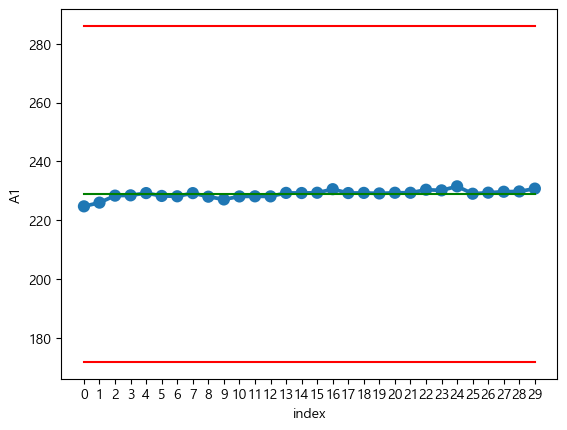

In [43]:
# Seaborn 관리도 시각화 
sns.pointplot(data=df1_A1_Xbar.iloc[0:30] , x='index', y='A1')
sns.lineplot(data=df1_A1_Xbar.iloc[0:30] , x='index', y='Center', color='g')
sns.lineplot(data=df1_A1_Xbar.iloc[0:30] , x='index', y='USL', color='r')
sns.lineplot(data=df1_A1_Xbar.iloc[0:30] , x='index', y='LSL', color='r')

In [44]:
# Plotly 관리도 시각화 
fig1 = px.line(df1_A1_Xbar.iloc[0:30], x='index', y='A1')
fig1.update_traces(mode='markers+lines')
fig1.add_hline(y=center, line_color='Blue')
fig1.add_hline(y=USL, line_color='Red')
fig1.add_hline(y=LSL, line_color='Red')
fig1.update_layout(yaxis_range = [LSL-10, USL+10])

# Imbalanced Data Sampling 

- 분류 (Classification) 
- 데이터 비율이 크게 차이가 발생한 경우 한쪽에 맞춰 데이터를 늘리거나 줄이는 작업 
    - Under Sampling : 데이터의 비율이 적은 값에 맞춰 데이터를 줄여주는 작업
        - Random Under Sampling : 비율이 많은 쪽의 데이터를 무작위 추출하여 줄임 
        - Tomek's Link : 서로 다른 값의 인접한 항목을 묶어 많은쪽의 데이터를 삭제 
            - 데이터의 비율이 한쪽이 적더라도 분류 경계 명확해 짐, 분류모델성능 ↑
            - 범주형 항목이 다수 있거나, 분류경계가 매우 모호한 경우 
        - CNN (Condensed Nearest Neighbor) : 비율이 많은 쪽에 데이터에서 밀도가 높은 부분의 데이터를 삭제 
        - One Sided Selection (Tomek's Link + CNN) 
            
    - Over Sampling : 데이터의 비율이 높은 값에 맞춰 데이터를 생성하는 작업 
        - Random Over Sampling : 비율이 적은 데이터를 무작위 생성하여, 많은쪽으로 맞춤 
        - SMOTE (Synethic Minority Over Sampling Technique) : KNN(K 최근접이웃)알고리즘을 이용하여, 비율이 적은쪽의 데이터를 K개의 인접개수 만큼 묶은 뒤, 묶인 데이터 내 중심점을 찾아 데이터를 생성 
        - ADASYN (Adaptive Synethic Sampling) : SMOTE기법을 이용해 데이터를 생성하는 단계에서 임의의 값(Noise, 감마밀도함수)을 더하여서 더 사실적인 데이터를 생성하는 기법 
        
- 공정 : 불량여부 Y -> 정상 950 / 불량 50
    - under sampling : 정상 50 / 불량 50    

In [45]:
from imblearn.under_sampling import RandomUnderSampler

In [46]:
df1['State'].unique()

array(['계약확정', '기간만료', '해약확정', '해약진행중'], dtype=object)

In [47]:
df1['Target']= df1['State'].replace({'계약확정':0, '기간만료':0, 
                                     '해약확정':1, '해약진행중':1})
df1['Target'].value_counts()

0    50665
1      636
Name: Target, dtype: int64

In [48]:
Y = df1['Target']
X = df1[['Age','Term','Amount_Month','Gender','Product_Type']]

In [49]:
under_sampler = RandomUnderSampler()
under_sampler.fit(X,Y) # 데이터를 Under Sampling 할 수식을 구축 

RandomUnderSampler()

In [50]:
X_under, Y_under = under_sampler.fit_resample(X,Y)
Y_under.value_counts()

0    636
1    636
Name: Target, dtype: int64

In [51]:
from imblearn.under_sampling import TomekLinks

In [52]:
df_clean = df1.dropna()

In [53]:
under_sampler = TomekLinks()
under_sampler.fit(df_clean[['Age','Term']], df_clean['Target'])
X_under, Y_under = under_sampler.fit_resample(df_clean[['Age','Term']], 
                                              df_clean['Target'])
Y_under.value_counts()

0    40137
1      510
Name: Target, dtype: int64

In [54]:
from imblearn.over_sampling import SMOTE

In [55]:
over_sampler = SMOTE()
over_sampler.fit( df_clean[['Age','Term']], df_clean['Target'] )
X_over, Y_over = over_sampler.fit_resample(df_clean[['Age','Term']], 
                                              df_clean['Target'])
Y_over.value_counts()

0    40137
1    40137
Name: Target, dtype: int64

In [56]:
make_pipeline(preprocessing_pipe, SMOTE(), DecisionTreeRegressor())

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Amount_Month',
                                                   'Term']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  ['Gender',
                                                   'Product_Type'])])),
                ('smote', SMOTE()),
                ('decisiontreeregressor', DecisionTreeRegressor())])

# Mission 9 
**New Member 15:30 까지 / 전체 17:00 까지**
- df1_merge 이용하여 아래의 문제를 해결하고자 한다. 

## 1번

In [57]:
# 1. 'tag' 항목의 각 값들의 빈도수를 계산 
df1_merge['tag'].value_counts()

NE280PV    373
NE282PV     75
NE280V      13
E280PV      13
Name: tag, dtype: int64

## 2번

In [58]:
# 2. 'Y1A'에서 3000이상인 값을 추출하여, 높은 순서대로 정렬한 뒤, 
#     tag 별 A1 값의 평균을 계산 
cond1 = (df1_merge['Y1A']>=3000)
df1_merge[cond1].sort_values(by='Y1A',
                             ascending=False).pivot_table(index='tag',
                                                          values='A1',aggfunc='mean')

,A1
tag,
E280PV,176.522720
NE280PV,230.525440
NE280V,228.820843
NE282PV,230.657998


## 3번

In [59]:
# 3. 'dt_round' 값을 이용해, 연도/월/일자 를 추출하여 새로운 변수로 선언 
df1_merge['Year'] = df1_merge['dt_round'].dt.year
df1_merge['Month'] = df1_merge['dt_round'].dt.month
df1_merge['Day'] = df1_merge['dt_round'].dt.day

## 4번

In [60]:
# 4. '일'별 'Y1A'의 합을 Table 형태로 계산 
df1_merge.pivot_table(index='Day',values='Y1A',aggfunc='sum').T
# .T : 전치 행렬 

Day,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
Y1A,126511.524,91771.302,289396.886,143216.537,144191.586,87539.926,77805.043,81396.942,35236.577,26401.142,...,204393.586,196859.771,188017.826,190563.777,177771.217,169103.425,126507.49,121952.888,137688.023,118385.623


## 5번

In [61]:
# 5. 'tag'항목에서 NE282PV 항목을 추출하여, **일별***로 A1~A6 값의 평균을 계산 
#    (Pivot_table X / resample 사용) 
cond1 = (df1_merge['tag']=='NE282PV')
df_clean_day = df1_merge.loc[cond1].set_index('dt_round').resample('1D').mean()
df_clean_day[['A1','A2','A3','A4','A5','A6']].dropna()

,A1,A2,A3,A4,A5,A6
dt_round,,,,,,
2018-12-31,229.590635,230.662697,231.783269,230.581694,230.047135,228.058751
2019-01-14,230.820579,232.088655,233.016918,232.093023,231.618933,229.559233
2019-01-15,230.923918,231.898059,233.000520,231.602043,231.059655,228.953803
2019-01-16,229.748754,230.840738,231.995553,230.715121,230.204467,228.094464
2019-01-17,231.317947,232.260641,232.989705,231.925774,231.203691,229.096735
2019-01-19,229.235814,232.185980,234.400608,234.196921,234.559251,232.722947
2019-01-20,226.194814,229.397951,232.025752,232.183624,233.008756,231.314809
2019-01-21,231.314295,233.707146,235.510813,234.846598,234.621040,232.629906
2019-01-25,229.602128,231.479119,233.073132,232.318212,232.230424,230.311868


## 6번

<AxesSubplot:xlabel='index', ylabel='A1'>

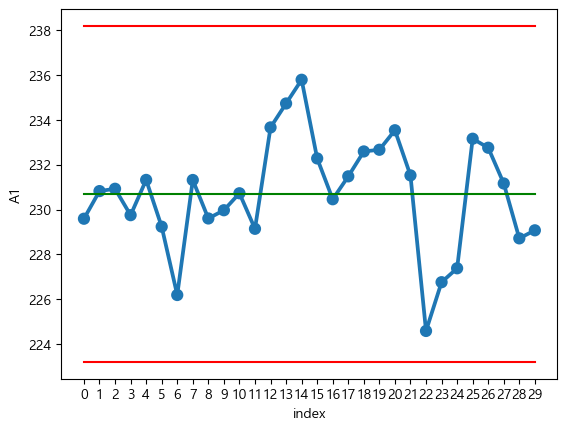

In [62]:
# 6. 위에서 계산된 테이블을 df_clean_day 선언을 한 뒤, 
#     결측값을 제거하고, A1 값에 대한 Xbar - sd 관리도를 시각화 (index 주의)
df_clean_day1 = df_clean_day.dropna()

df1_cc = df_clean_day1[['A1']].reset_index().reset_index()
df1_cc['Center'] = df1_cc['A1'].mean()
df1_cc['USL'] = df1_cc['A1'].mean() + (3 * df1_cc['A1'].std())
df1_cc['LSL'] = df1_cc['A1'].mean() - (3 * df1_cc['A1'].std())

sns.pointplot(data=df1_cc.iloc[0:30], x='index', y='A1')
sns.lineplot(data=df1_cc.iloc[0:30], x='index', y='Center', color='g')
sns.lineplot(data=df1_cc.iloc[0:30], x='index', y='USL', color='r')
sns.lineplot(data=df1_cc.iloc[0:30], x='index', y='LSL', color='r')

## 7번

In [63]:
# 7. df1_merge에서 결측값을 제거 한 뒤, tag의 'NE280PV'값과 'NE282PV'값에 대해 A1값이 평균의 차이가 있는지 가설 검정을 수행하고, 
# 평균을 비교하는 그래프를 시각화 하시오.
df3 = df1_merge.dropna()
# 귀무가설 : 두 집단의 A1 값의 평균의 차이가 없다.
# 대립가설 : 두 집단의 A1 값의 평균의 차이가 있다. 
df3_280pv = df3.loc[df3['tag']=='NE280PV']
df3_282pv = df3.loc[df3['tag']=='NE282PV']

In [64]:
# 7-1. A1 값이 정규성을 따르는가 검정 
# 귀무 : A1 분포가 정규분포를 따른다. 
# 대립 : A1 분포가 정규분포를 따르지 않는다.
df3_normal = df3.loc[df3['tag'].isin(['NE280PV', 'NE282PV'])]
stats.normaltest(df3_normal['A1'])
# p.value < 0.05 / 대립가설 참 / A1 분포가 정규분포를 따르지 않는다.

NormaltestResult(statistic=119.92923009669069, pvalue=9.071906699572857e-27)

<AxesSubplot:xlabel='tag', ylabel='A1'>

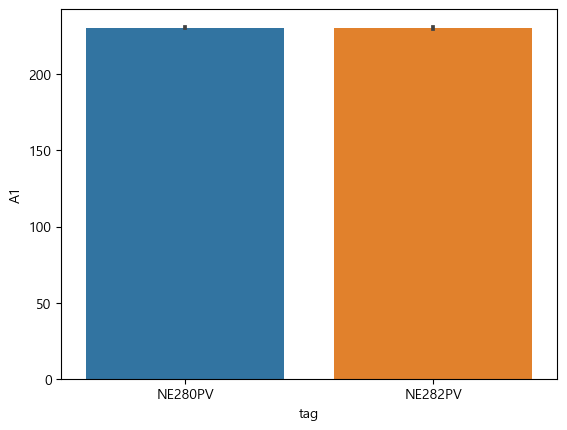

In [65]:
stats.ranksums(df3_280pv['A1'], df3_282pv['A1'])
# P.value > 0.05 / 귀무가설 참 / 두 집단의 A1 값의 평균의 차이가 없다.
sns.barplot(data=df3_normal, x='tag', y='A1')

## 8번

<AxesSubplot:xlabel='A1', ylabel='Y1A'>

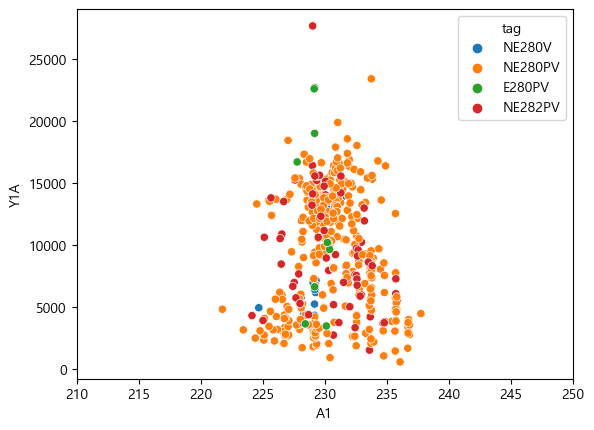

In [66]:
# 8. 'Y1A'값과 'A1'값의 산점도를 tag에 따라 색상을 나누어 시각화하고, 
#     두 값이 상관성이 있는지 가설검정을 수행 
plt.xlim([210,250])
sns.scatterplot(data=df1_merge, x='A1', y='Y1A', hue='tag')

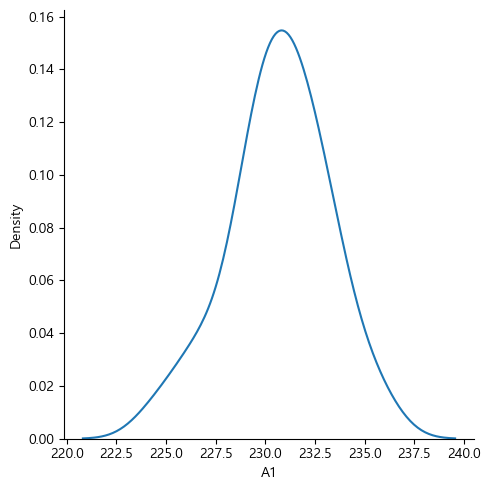

In [67]:
# 8-1. 두 연속형 데이터가 정규성을 따르는가? 
stats.normaltest(df_clean_day1['A1']) # P.value > 0.05 / 귀무가설 참 / 정규분포 
sns.displot(data=df_clean_day1, x='A1', kind='kde')

c:\Python310\lib\site-packages\seaborn\axisgrid.py:88: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from current font.



c:\Python310\lib\site-packages\IPython\core\events.py:89: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from current font.

c:\Python310\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning:

Glyph 8722 (\N{MINUS SIGN}) missing from current font.



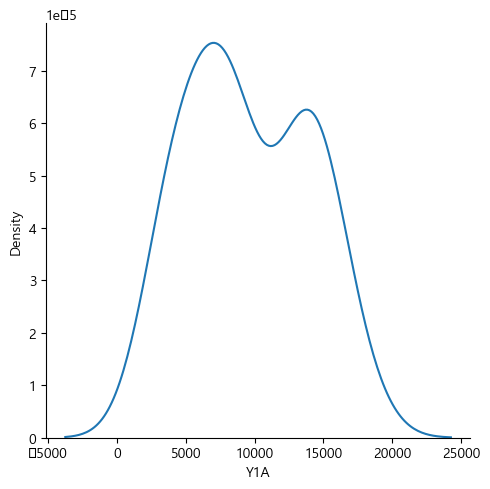

In [68]:
stats.normaltest(df_clean_day1['Y1A']) # P.value < 0.05 / 대립가설 참 / 비정규분포 
sns.displot(data=df_clean_day1, x='Y1A', kind='kde')

In [69]:
# 귀무가설 : 두 연속형 숫자데이터가 서로 상관성이 없다. 
# 대립가설 : 두 연속형 숫자데이터가 서로 상관성이 있다.
stats.spearmanr(df_clean_day1['A1'], df_clean_day1['Y1A'])
# P.value > 0.05 / 귀무가설 참 / 두 연속형 숫자데이터가 서로 상관성이 없다

SpearmanrResult(correlation=-0.32458286985539486, pvalue=0.08011732925902561)

## 9번

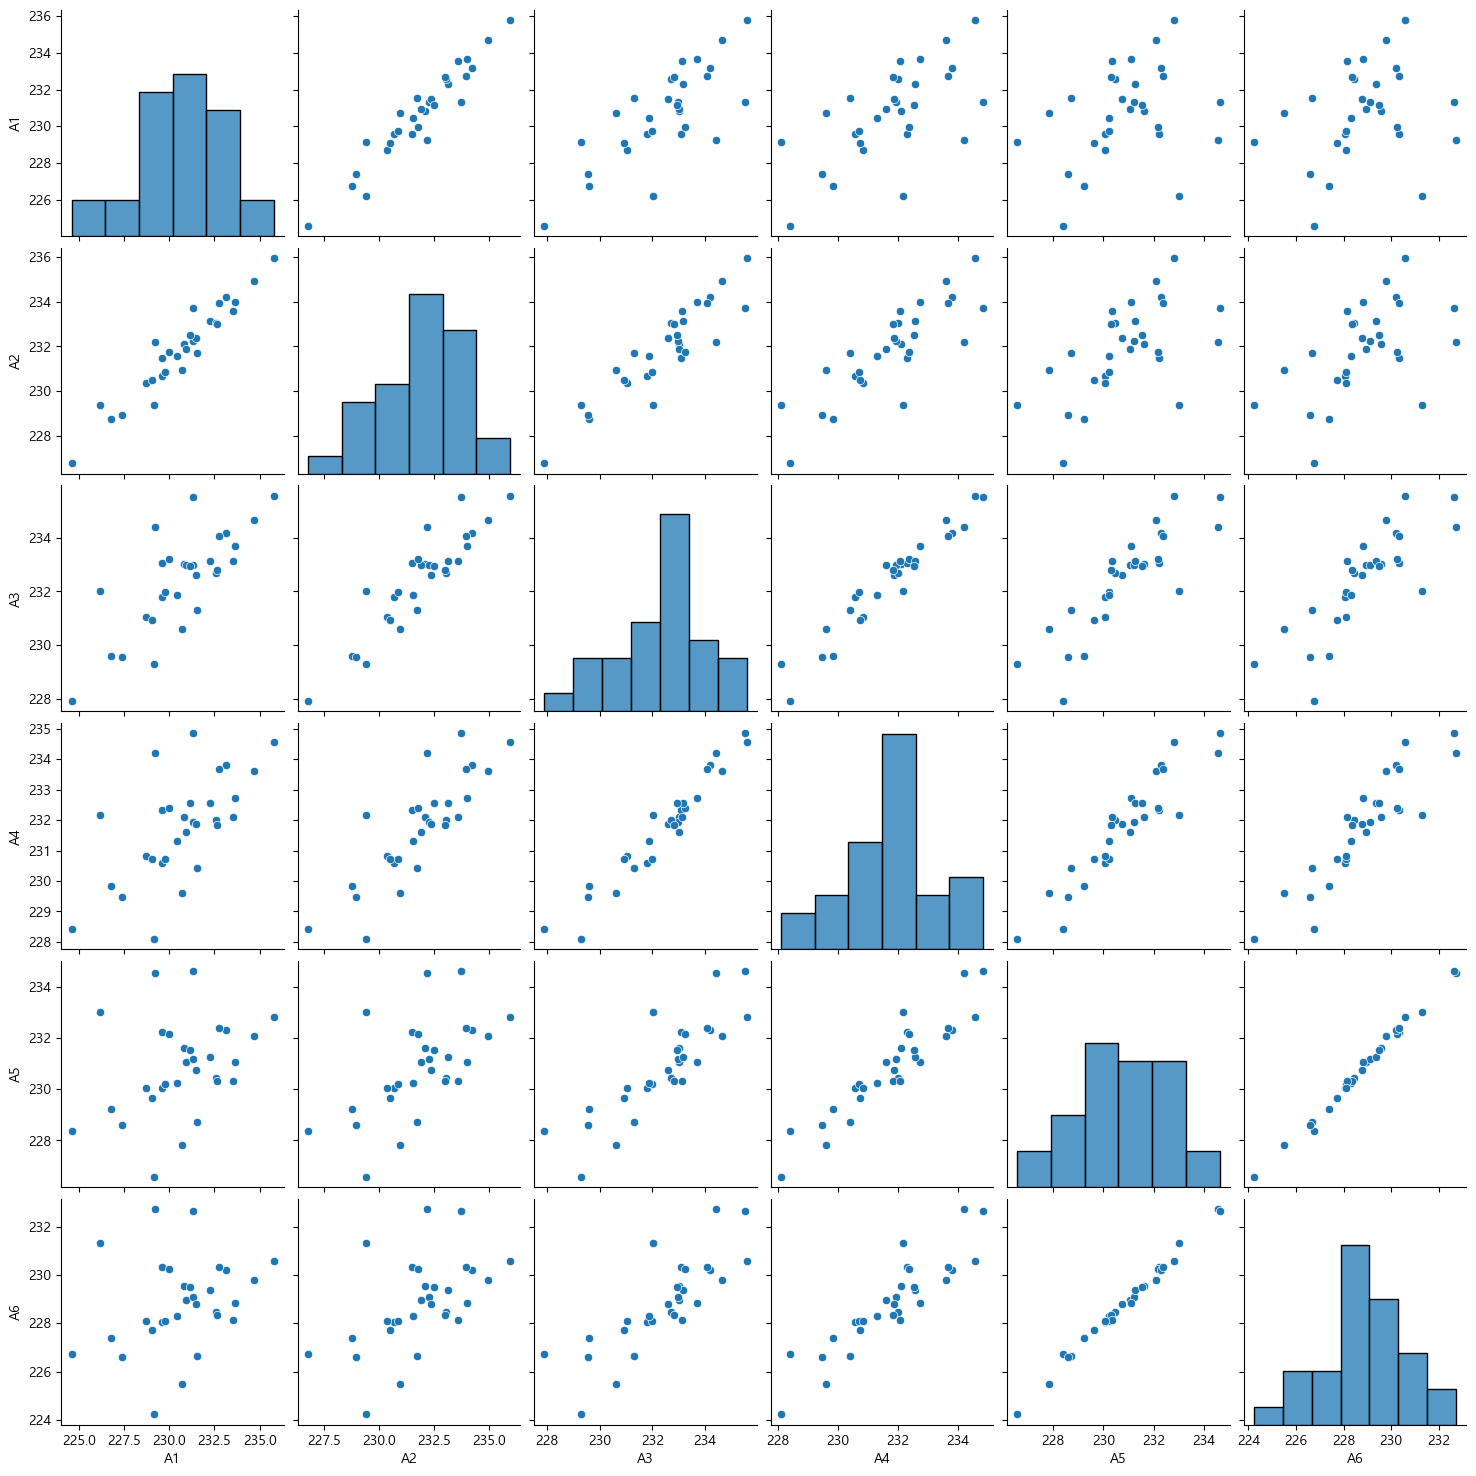

In [70]:
# 9. 'A1'부터 'A6'까지 6개 항목의 분포를 확률분포로 시각화하고, 정규성 검정을 수행
sns.pairplot(data=df_clean_day1[['A1','A2','A3','A4','A5','A6']])

In [71]:
for i in ['A1','A2','A3','A4','A5','A6']:
    print(stats.normaltest(df_clean_day1[i]))

NormaltestResult(statistic=1.1675498702394909, pvalue=0.5577887708565992)
NormaltestResult(statistic=1.2095389321182908, pvalue=0.5462003298412055)
NormaltestResult(statistic=1.9992060969758167, pvalue=0.36802550045919236)
NormaltestResult(statistic=0.38287115005003985, pvalue=0.8257728237863143)
NormaltestResult(statistic=0.31732024412265014, pvalue=0.8532863228866931)
NormaltestResult(statistic=0.8724720881449628, pvalue=0.6464651136663906)


## 10번

In [72]:
# 10. 'A1'값을 Robust Scaling 실시하고,
#     스케일링 된 값이 0보다 작은 데이터를 추출하여 'A1'값의 평균을 계산하시오.
from sklearn.preprocessing import RobustScaler
scaler = RobustScaler()
scaler.fit(df_clean_day1[['A1']])

RobustScaler()

In [73]:
df_scale = pd.DataFrame(scaler.fit_transform(df_clean_day1[['A1']]))
df_scale.loc[df_scale[0] < 0 ][0].mean()

-0.6505730322025557

## 11번

In [1]:
# 11. 'Y1A'값이 상위 90%이상인 값을 1, 미만인 값을 0로 변환하여 'Target'값으로 선언한 뒤, A1 ~ A6 값을 넣었을 때, Target을 분류하는 분류모델 생성
#    - 8:2 비율로 학습데이터와 검증 데이터 분할 
#    - Min Max Scaling 기법과 Imputation(평균대치), 교차검증 5회 
#    - 가장 성능이 좋은 모델을 찾아, model_target.sav이름으로 저장 
#    - 평가 : 학습능력평가 / 일반화능력평가 